In [1]:
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('train.csv/train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv('test.csv/test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv('songs.csv/songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv('members.csv/members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv('song_extra_info.csv/song_extra_info.csv')

In [3]:
members.registration_init_time = members.registration_init_time.apply(lambda x : time.mktime(x.timetuple()))
members.expiration_date = members.expiration_date.apply(lambda x : time.mktime(x.timetuple()))
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

In [4]:
###### See if artist is in the top k artist
for item in ['artist_name', 'composer', 'lyricist']:
    vc = songs[item].value_counts().argsort()
    for i in [10, 20, 50, 100]:
        new_col = "is_in_top_{}_{}".format(i, item)
        keys = list(dict(vc[:i]).keys())
        songs[new_col] = songs.apply(lambda row: 1 if row[item] in keys else 0, axis=1)

In [5]:
songs.song_length.fillna(songs.song_length.mean(),inplace=True)

In [6]:
# train = train.merge(songs, on='song_id', how='left')
# train = train.merge(members, on='msno', how='left')
# train = train.merge(songs_extra, on = 'song_id', how = 'left')

In [7]:
##### See if artist composer and lyricist are the same
songs['same_c_l'] = songs.apply(lambda row: 1 if row['composer'] == row['lyricist'] else 0, axis= 1)
songs['all_same'] = songs.apply(lambda row: 1 if row['composer'] == row['lyricist'] and row['composer'] == row['artist_name'] else 0, axis= 1)

In [8]:
songs.drop(['artist_name', 'composer', 'lyricist'], inplace=True, axis=1)

In [9]:
songs['first_genre'] = songs.genre_ids.apply(str).apply(lambda row: row.split('|')[0])

In [10]:
songs.drop('genre_ids', inplace=True, axis=1)

In [11]:
songs.language.fillna(songs.language.mode()[0], inplace=True)

In [12]:
#Song feature finished

In [13]:
songs_extra.song_year.fillna(songs_extra.song_year.mode()[0], inplace=True)

In [14]:
#song extra finished

In [15]:
members['is_male'] = members.apply(lambda row: 1 if row.gender == 'male' else 0, axis= 1)
members['is_female'] = members.apply(lambda row: 1 if row.gender == 'female' else 0, axis= 1)

In [16]:
members.drop('gender', inplace=True, axis=1)

In [17]:
members['missing_bd'] = members.apply(lambda row: 1 if row.bd >= 65 or row.bd <= 12 else 0, axis=1)

In [18]:
#finish member

In [19]:
train = train.merge(songs, on='song_id', how='left')
train = train.merge(members, on='msno', how='left')
train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs, on='song_id', how='left')
test = test.merge(members, on='msno', how='left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')

In [20]:
a = dict(train.isnull().any())

In [21]:
keys = [k for k in list(a.keys()) if a[k] == True]

In [22]:
for k in keys:
    train[k].fillna(train[k].mode()[0], inplace=True)
    test[k].fillna(test[k].mode()[0], inplace=True)

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cat = ['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type']
def label(df,var):
    for i in var:
        df[i]= le.fit_transform(df[i])
label(train, cat)
label(test, cat)

In [24]:
X = train.loc[:, train.columns != "target"]
y = train.loc[:, "target"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [25]:
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier()
bag.fit(X, y)
bag.score(X_valid, y_valid)

0.98366962976216621

In [26]:
X_test = test.drop(['id'], axis=1)
ids = test['id'].values
predictions = bag.predict(X_test)

In [27]:
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = predictions
subm.to_csv('bagging_submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

In [112]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
rf.score(X_valid, y_valid)

0.68760569413155281

In [113]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
clf.score(X_valid, y_valid)

0.64505694402650249

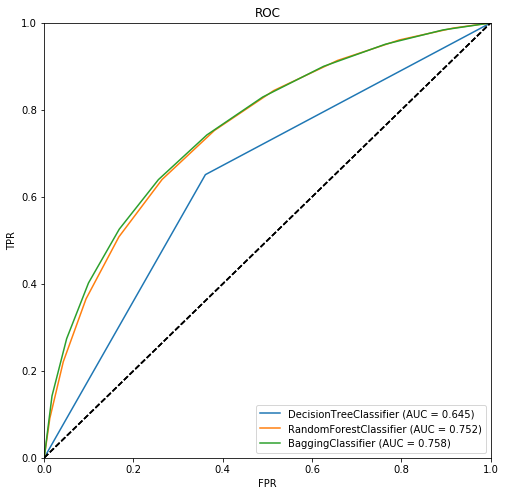

In [114]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 8
for model in [clf, rf, bag]:
    predict_Y = model.predict_proba(X_valid)[:,1]
    fpr, tpr, thresholds = roc_curve(y_valid, predict_Y)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = str(model).split('(')[0]+ ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")